### Importing Libraries

In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
from chart_studio.plotly import plotly as ply
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.metrics import mean_squared_error,mean_squared_log_error
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from itertools import product  
init_notebook_mode(connected=True)

### Reading data from JSON file

In [14]:
df = pd.read_json('failuretime.json',)
df.head()

,time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [15]:
df.shape

(93142, 1)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
time    93142 non-null object
dtypes: object(1)
memory usage: 727.8+ KB


In [17]:
from datetime import datetime 
df['timestamp']=pd.to_datetime(df['time'],format='%Y-%m-%d %H:%M:%S')
#df.drop(columns=['time'],axis=1,inplace=True)
df['timestamp']=sorted(df['timestamp'])

In [18]:
df.head()

,time,timestamp
0,1970-01-01 20:13:18,1970-01-01 20:12:16
1,1970-01-01 20:16:10,1970-01-01 20:13:18
2,1970-01-01 20:16:37,1970-01-01 20:16:10
3,1970-01-01 20:16:36,1970-01-01 20:16:36
4,1970-01-01 20:26:21,1970-01-01 20:16:37


In [19]:
df_segmented = df.groupby(pd.Grouper(key='timestamp', freq='15Min')).count().reset_index()
df_segmented.columns=['15min_period','num_failures']
df_segmented.head()

,15min_period,num_failures
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


In [20]:
df_segmented.shape

(9788, 2)

In [21]:
# Authenticating with my account
#ply.tools.set_credentials_file(username='vithika94',api_key='tIalakUHBKlcbixDTPkz')

In [22]:
#df1.plotly.offline.iplot(title="Failure Times", theme='pearl')
data = [go.Scatter(x=df_segmented.ix[:,0],y=df_segmented.ix[:,1])]
layout = go.Layout(
title='Failure Time',
xaxis=dict(title='15min_period'),
yaxis=dict(title='num_failures'))

fig = go.Figure(data=data, layout=layout)
ply.iplot(fig, sharing = 'public')

#### The data seems to be stationary and there seems to be no trend in the data. The data also seems to have seasonality.
#### Hence, seasonality decomposition is required.  

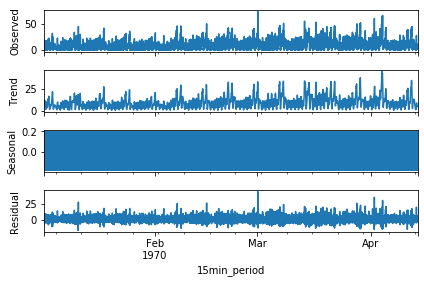

In [33]:
from chart_studio.plotly import plot_mpl
import statsmodels.api as sm
#from statsmodels.tsa.seasonal import seasonal_decompose
result = sm.tsa.seasonal_decompose(df_segmented['num_failures'],freq =15)
result.plot()
plt.show()

#### Setting 15min_period as index 

In [24]:
df_segmented.set_index('15min_period',inplace=True)
df_segmented.head()

,num_failures
15min_period,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


# ACF plot

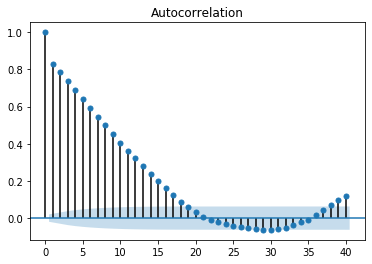

In [42]:
sm.graphics.tsa.plot_acf(df_segmented['num_failures'].values.squeeze(), lags=40)
plt.show()

# PACF plot

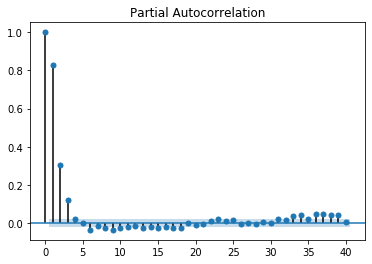

In [43]:
sm.graphics.tsa.plot_pacf(df_segmented['num_failures'].values.squeeze(), lags=40)
plt.show()

### Plotting Moving Average with respect to past 4 periods

In [25]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

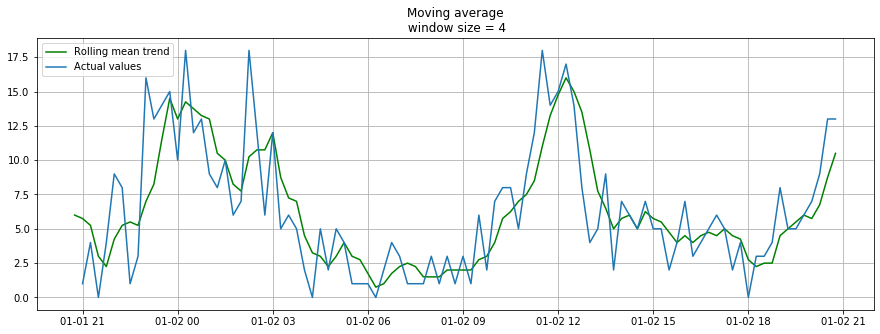

In [26]:
plotMovingAverage(df_segmented[:100], 4) 

### Mean Absolute Percentage Error

In [27]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Creating function for Time-Series Cross-Validation

In [28]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=1):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=2) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

### Creating class to implement Holt-Winters Forecasting Model

In [29]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

### Implementing Holt-Winters Model with Newton Conjugate Gradient and Triple Exponential Smoothing

In [30]:
%%time
data = df_segmented.num_failures[:30000] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 4 periods
model = HoltWinters(data, slen = 1, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 4, scaling_factor = 3)
model.triple_exponential_smoothing()

1.0 0.0008354905390401401 0.999999987208239
Wall time: 34.9 s


### Defining Plot to see Model Accuracy

In [31]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

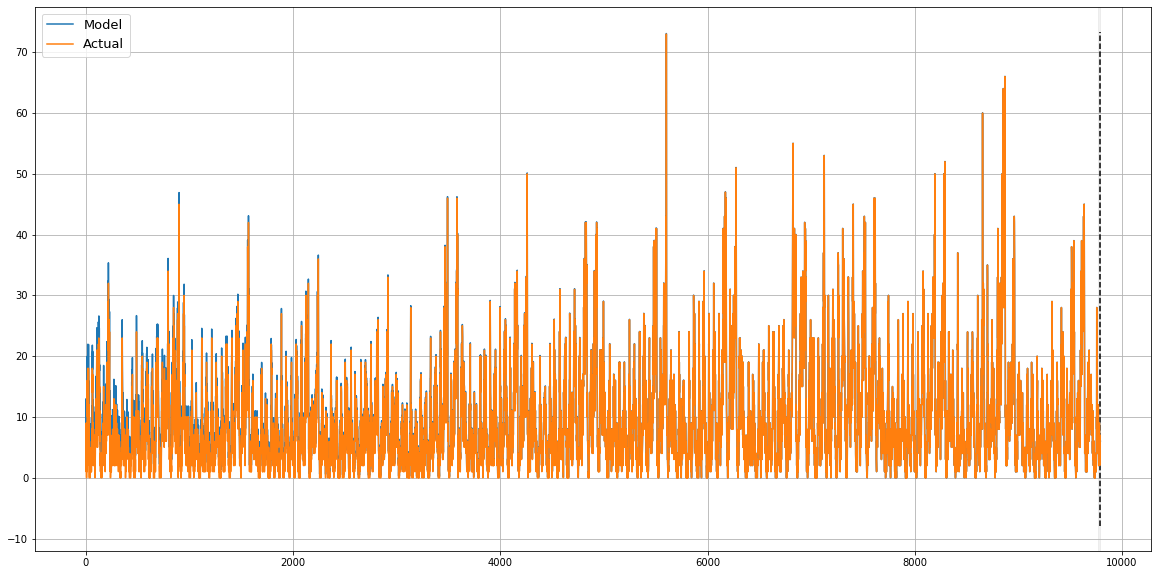

In [32]:
plotHoltWinters(df_segmented.num_failures)

### Appending the predictions to the dataframe

In [37]:
df_segmented['next_hr_prediction'] = model.result[:len(df_segmented)]
df_segmented['next_hr_prediction'] = df_segmented['next_hr_prediction'].astype(int)
df_segmented.head()

,num_failures,next_hr_prediction
15min_period,,
1970-01-01 20:00:00,2,2
1970-01-01 20:15:00,6,10
1970-01-01 20:30:00,9,12
1970-01-01 20:45:00,7,10
1970-01-01 21:00:00,1,4


In [45]:
df_segmented.tail(4)

,num_failures,next_hr_prediction
15min_period,,
1970-04-13 18:00:00,5,4
1970-04-13 18:15:00,2,1
1970-04-13 18:30:00,7,6
1970-04-13 18:45:00,6,5
